In [30]:
%matplotlib inline

In [31]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
from utils import plot_batch

In [32]:
path = "../data"

In [33]:
idg = IDG()

In [34]:
classes = ['cat','dog']
class_mode = 'binary'
batch_size = 16
path_train = path + "/train"
path_test = path + "/train"
images = idg.flow_from_directory(path_train, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 25346 images belonging to 2 classes.


In [35]:
num_of_samples = 25000.

In [36]:
batch, labels = images.next()

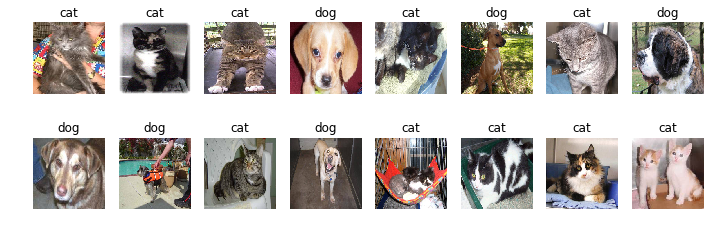

In [37]:
plot_batch(batch,labels,classes)

In [38]:
batch.shape

(16, 256, 256, 3)

In [39]:
from keras.applications.vgg16 import VGG16

In [40]:
image_shape = batch.shape[1:]
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=image_shape, pooling=None)

In [41]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [42]:
from keras.layers import Flatten, Dense
from keras.models import Model

vgg16_top = vgg16_base.output
vgg16_top = Flatten()(vgg16_top)
# let's add a fully-connected layer
vgg16_top = Dense(1024, activation='relu')(vgg16_top)
# and a logistic layer -- let's say we have 2 classes
vgg16_top = Dense(1, activation='sigmoid')(vgg16_top)

# this is the model we will train
model = Model(inputs=vgg16_base.input, outputs=vgg16_top)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [44]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [45]:
num_batches = 100./batch_size
epochs = 1
steps_per_epoch = batch_size
# fine-tune the model
model.fit_generator(images, steps_per_epoch=num_batches, epochs=epochs)#, 
#                     validation_data=validation_generator, nb_val_samples=nb_validation_samples)

Epoch 1/1
7/6 [=================================] - 114s - loss: 3.4662 - acc: 0.6875


In [46]:
weights_file = path + '/dogs_vs_cats.h5'
model.save(weights_file)

In [17]:
model.predict('../data/test/1.jpg')

TypeError: Error when checking model : data should be a Numpy array, or list/dict of Numpy arrays. Found: ../data/test/1.jpg...